# HFSS-Mechanical MRI analysis

This example uses a coil tuned to 63.8 MHz to determine the temperature
rise in a gel phantom near an implant given a background SAR of 1 W/kg.

Here is the workflow:

Step 1: Simulate the coil loaded by the empty phantom:
Scale input to coil ports to produce desired background SAR of 1 W/kg at the location
that is to contain the implant.

Step 2: Simulate the coil loaded by the phantom containing the implant in the proper location:
View SAR in the tissue surrounding implant.

Step 3: Thermal simulation:
Link HFSS to the transient thermal solver to find the temperature rise in the tissue near the implant
versus the time.

Keywords: **multiphysics**, **HFSS**, **Mechanical AEDT**, **Circuit**.

## Perform imports and define constants
Perform required imports.

In [1]:
import os.path
import tempfile
import time

from ansys.aedt.core import Hfss, Icepak, Mechanical
from ansys.aedt.core.examples import downloads

Define constants.

In [2]:
AEDT_VERSION = "2025.2"
NUM_CORES = 4
NG_MODE = False  # Open AEDT UI when it is launched.

## Create temporary directory

Create a temporary directory where downloaded data or
dumped data can be stored.
If you'd like to retrieve the project data for subsequent use,
the temporary folder name is given by ``temp_folder.name``.

In [3]:
temp_folder = tempfile.TemporaryDirectory(suffix=".ansys")

## Load project

Open AEDT and the ``background_SAR.aedt`` project. This project
contains the phantom and airbox. The phantom consists of two objects: ``phantom`` and ``implant_box``.

Separate objects are used to selectively assign mesh operations.
Material properties defined in  this project already contain electrical and thermal properties.

In [4]:
project_path = downloads.download_file(source="mri", local_path=temp_folder.name)
project_name = os.path.join(project_path, "background_SAR.aedt")
hfss = Hfss(
    project=project_name,
    version=AEDT_VERSION,
    non_graphical=NG_MODE,
    new_desktop=True,
)

PyAEDT INFO: Parsing C:\Users\ansys\AppData\Local\Temp\tmpzp3ybtup.ansys\mri\background_SAR.aedt.


PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)].


PyAEDT INFO: PyAEDT version 0.25.dev0.


PyAEDT INFO: Initializing new Desktop session.


PyAEDT INFO: Log on console is enabled.


PyAEDT INFO: Log on file C:\Users\ansys\AppData\Local\Temp\pyaedt_ansys_4606e45d-8715-4b44-abac-d31a8d1ae69f.log is enabled.


PyAEDT INFO: Log on AEDT is disabled.


PyAEDT INFO: Starting new AEDT gRPC session.


PyAEDT INFO: AEDT installation Path C:\Program Files\ANSYS Inc\v252\AnsysEM


PyAEDT INFO: Client application successfully started.


PyAEDT INFO: File C:\Users\ansys\AppData\Local\Temp\tmpzp3ybtup.ansys\mri\background_SAR.aedt correctly loaded. Elapsed time: 0m 10sec


PyAEDT INFO: New AEDT gRPC session session started on port 50051.


PyAEDT INFO: 2025.2 version started with process ID 4340.


PyAEDT WARNING: Service Pack is not detected. PyAEDT is currently connecting in Insecure Mode.


PyAEDT WARNING: Please download and install latest Service Pack to use connect to AEDT in Secure Mode.


PyAEDT INFO: Debug logger is disabled. PyAEDT methods will not be logged.


PyAEDT INFO: Project background_SAR has been opened.


PyAEDT INFO: Active Design set to backgroundSAR


PyAEDT INFO: Active Design set to backgroundSAR


PyAEDT INFO: Aedt Objects correctly read


## Insert 3D component

The MRI coil is saved as a separate 3D component.

‒ 3D components store geometry (including parameters),
material properties, boundary conditions, mesh assignments,
and excitations.
‒ 3D components make it easy to reuse and share parts of a simulation.

In [5]:
component_file = os.path.join(project_path, "coil.a3dcomp")
hfss.modeler.insert_3d_component(input_file=component_file)

PyAEDT INFO: Modeler class has been initialized! Elapsed time: 0m 1sec


Class: ansys.aedt.core.modeler.cad.components_3d.UserDefinedComponent

## Define convergence criteria

 On the **Expression Cache** tab, define additional convergence criteria for self
 impedance of the four coil ports.

Set each of these convergence criteria to 2.5 ohm.
This example limits the number of passes to two to reduce simulation time.

In [6]:
im_traces = hfss.get_traces_for_plot(
    get_mutual_terms=False, category="im(Z", first_element_filter="Coil1_p*"
)

hfss.setups[0].enable_expression_cache(
    report_type="Modal Solution Data",
    expressions=im_traces,
    isconvergence=True,
    isrelativeconvergence=False,
    conv_criteria=2.5,
    use_cache_for_freq=False,
)
hfss.setups[0].props["MaximumPasses"] = 1

## Edit sources

The 3D component of the MRI coil contains all the ports,
but the sources for these ports are not yet defined.
Browse to and select the ``sources.csv`` file.
The sources in this file were determined by tuning the coil at 63.8 MHz.
Notice that ``input_scale`` is a multiplier that lets you quickly adjust the coil excitation power.

In [7]:
hfss.edit_source_from_file(os.path.join(project_path, "sources.csv"))

True

## Run simulation

Save and analyze the project.

In [8]:
hfss.save_project(file_name=os.path.join(project_path, "solved.aedt"))
hfss.analyze(cores=NUM_CORES)

PyAEDT INFO: Project solved Saved correctly


PyAEDT INFO: Project solved Saved correctly


PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/HFSS correctly changed.


PyAEDT INFO: Solving all design setups. Analysis started...


PyAEDT INFO: Design setup None solved correctly in 0.0h 1.0m 44.0s


PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/HFSS correctly changed.


True

## Plot SAR on cut plane in phantom

Ensure that the SAR averaging method is set to ``Gridless``.
Plot ``Average_SAR`` on the global YZ plane.
Draw ``Point1`` at the origin of the implant coordinate system.

In [9]:
hfss.sar_setup(
    assignment=-1,
    average_sar_method=1,
    tissue_mass=1,
    material_density=1,
)
hfss.post.create_fieldplot_cutplane(
    assignment=["implant:YZ"], quantity="Average_SAR", filter_objects=["implant_box"]
)

hfss.modeler.set_working_coordinate_system("implant")
hfss.modeler.create_point(position=[0, 0, 0], name="Point1")

plot = hfss.post.plot_field(
    quantity="Average_SAR",
    assignment="implant:YZ",
    plot_type="CutPlane",
    show_legend=False,
    filter_objects=["implant_box"],
    export_path=hfss.working_directory,
    show=False,
)

PyAEDT INFO: SAR settings are correctly applied.


PyAEDT INFO: Parsing C:\Users\ansys\AppData\Local\Temp\tmpzp3ybtup.ansys\mri\solved.aedt.


PyAEDT INFO: File C:\Users\ansys\AppData\Local\Temp\tmpzp3ybtup.ansys\mri\solved.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: aedt file load time 0.1638178825378418


PyAEDT INFO: PostProcessor class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: PostProcessor class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Post class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Active Design set to backgroundSAR


PyAEDT INFO: Active Design set to backgroundSAR


EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

## Adjust input Power to MRI coil

Adjust the MRI coil’s input power so that the average SAR at ``Point1`` is 1 W/kg.
Note that the SAR and input power are linearly related.

To determine therequired input, calculate
``input_scale = 1/AverageSAR`` at ``Point1``.

In [10]:
sol_data = hfss.post.get_solution_data(
    expressions="Average_SAR",
    primary_sweep_variable="Freq",
    context="Point1",
    report_category="Fields",
)
sol_data.data_real()

hfss["input_scale"] = 1 / sol_data.data_real()[0]

PyAEDT INFO: Solution Data Correctly Loaded.


Time to initialize solution data:0.01572251319885254
Time to initialize solution data:0.01572251319885254


C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\ansys\aedt\core\visualization\post\solution_data.py:633: UserWarning: Method `data_real` is deprecated. Use :func:`get_expression_data` property instead.
  warnings.warn("Method `data_real` is deprecated. Use :func:`get_expression_data` property instead.")


## Analyze phantom with implant

Import the implant geometry.
Subtract the rod from the implant box.
Assign titanium to the imported object rod.
Analyze the project.

In [11]:
hfss.modeler.import_3d_cad(os.path.join(project_path, "implant_rod.sat"))

hfss.modeler["implant_box"].subtract(tool_list="rod", keep_originals=True)
hfss.modeler["rod"].material_name = "titanium"
hfss.analyze(cores=NUM_CORES)
hfss.save_project()

PyAEDT INFO: Step file C:\Users\ansys\AppData\Local\Temp\tmpzp3ybtup.ansys\mri\implant_rod.sat imported


PyAEDT INFO: Materials class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Project solved Saved correctly


PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/HFSS correctly changed.


PyAEDT INFO: Solving all design setups. Analysis started...


PyAEDT INFO: Design setup None solved correctly in 0.0h 1.0m 46.0s


PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/HFSS correctly changed.


PyAEDT INFO: Project solved Saved correctly


True

## Run a thermal simulation

Initialize a new Mechanical transient thermal analysis.
This type of analysis is available in AEDT in 2023 R2 and later as a beta feature.

In [12]:
mech = Mechanical(solution_type="Transient Thermal", version=AEDT_VERSION)

PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)].


PyAEDT INFO: PyAEDT version 0.25.dev0.


PyAEDT INFO: Returning found Desktop session with PID 4340!


PyAEDT INFO: No project is defined. Project solved exists and has been read.


PyAEDT INFO: No consistent unique design is present. Inserting a new design.


PyAEDT INFO: Added design 'Mechanical_K1J' of type Mechanical.


PyAEDT INFO: Aedt Objects correctly read


## Copy geometries

Copy bodies from the HFSS project. The 3D component is not copied.

In [13]:
mech.copy_solid_bodies_from(hfss)

PyAEDT INFO: Modeler class has been initialized! Elapsed time: 0m 0sec


True

## Link sources to EM losses

Link sources to the EM losses.
Assign external convection.

In [14]:
exc = mech.assign_em_losses(
    design=hfss.design_name,
    setup=hfss.setups[0].name,
    sweep="LastAdaptive",
    map_frequency=hfss.setups[0].props["Frequency"],
    surface_objects=mech.get_all_conductors_names(),
)

PyAEDT INFO: Materials class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Mapping HFSS EM Loss


PyAEDT INFO: Boundary EMLoss EMLoss_H5UUY4 has been created.


In [15]:
mech.assign_uniform_convection(
    assignment=mech.modeler["Region"].faces, convection_value=1
)

PyAEDT INFO: Boundary Convection Convection_9X6PFF has been created.


Convection_9X6PFF

## Create setup

Create a setup and edit properties.

In [16]:
setup = mech.create_setup()
# setup.add_mesh_link("backgroundSAR")
# mech.create_dataset1d_design("PowerMap", [0, 239, 240, 360], [1, 1, 0, 0])
# exc.props["LossMultiplier"] = "pwl(PowerMap,Time)"

mech.modeler.set_working_coordinate_system("implant")
mech.modeler.create_point(position=[0, 0, 0], name="Point1")
setup.props["Stop Time"] = 30
setup.props["Time Step"] = "10s"
setup.props["SaveFieldsType"] = "Every N Steps"
setup.props["N Steps"] = "2"

## Analyze project

Analyze the Mechanical project.

In [17]:
mech.analyze(cores=NUM_CORES)

PyAEDT INFO: Project solved Saved correctly


PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/Mechanical correctly changed.


PyAEDT INFO: Solving all design setups. Analysis started...


PyAEDT INFO: Design setup None solved correctly in 0.0h 3.0m 10.0s


PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/Mechanical correctly changed.


True

## Plot fields

Plot the temperature on cut plane.
Plot the temperature on the point.

PyAEDT INFO: Parsing C:\Users\ansys\AppData\Local\Temp\tmpzp3ybtup.ansys\mri\solved.aedt.


PyAEDT INFO: File C:\Users\ansys\AppData\Local\Temp\tmpzp3ybtup.ansys\mri\solved.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: aedt file load time 0.20543456077575684


PyAEDT INFO: PostProcessor class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Post class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Active Design set to Mechanical_K1J


PyAEDT INFO: Project solved Saved correctly


PyAEDT INFO: Solution Data Correctly Loaded.


Time to initialize solution data:0.013777017593383789
Time to initialize solution data:0.013777017593383789
PyAEDT INFO: Active Design set to Mechanical_K1J


PyAEDT INFO: Active Design set to Mechanical_K1J


Class: ansys.aedt.core.visualization.plot.pyvista.ModelPlotter

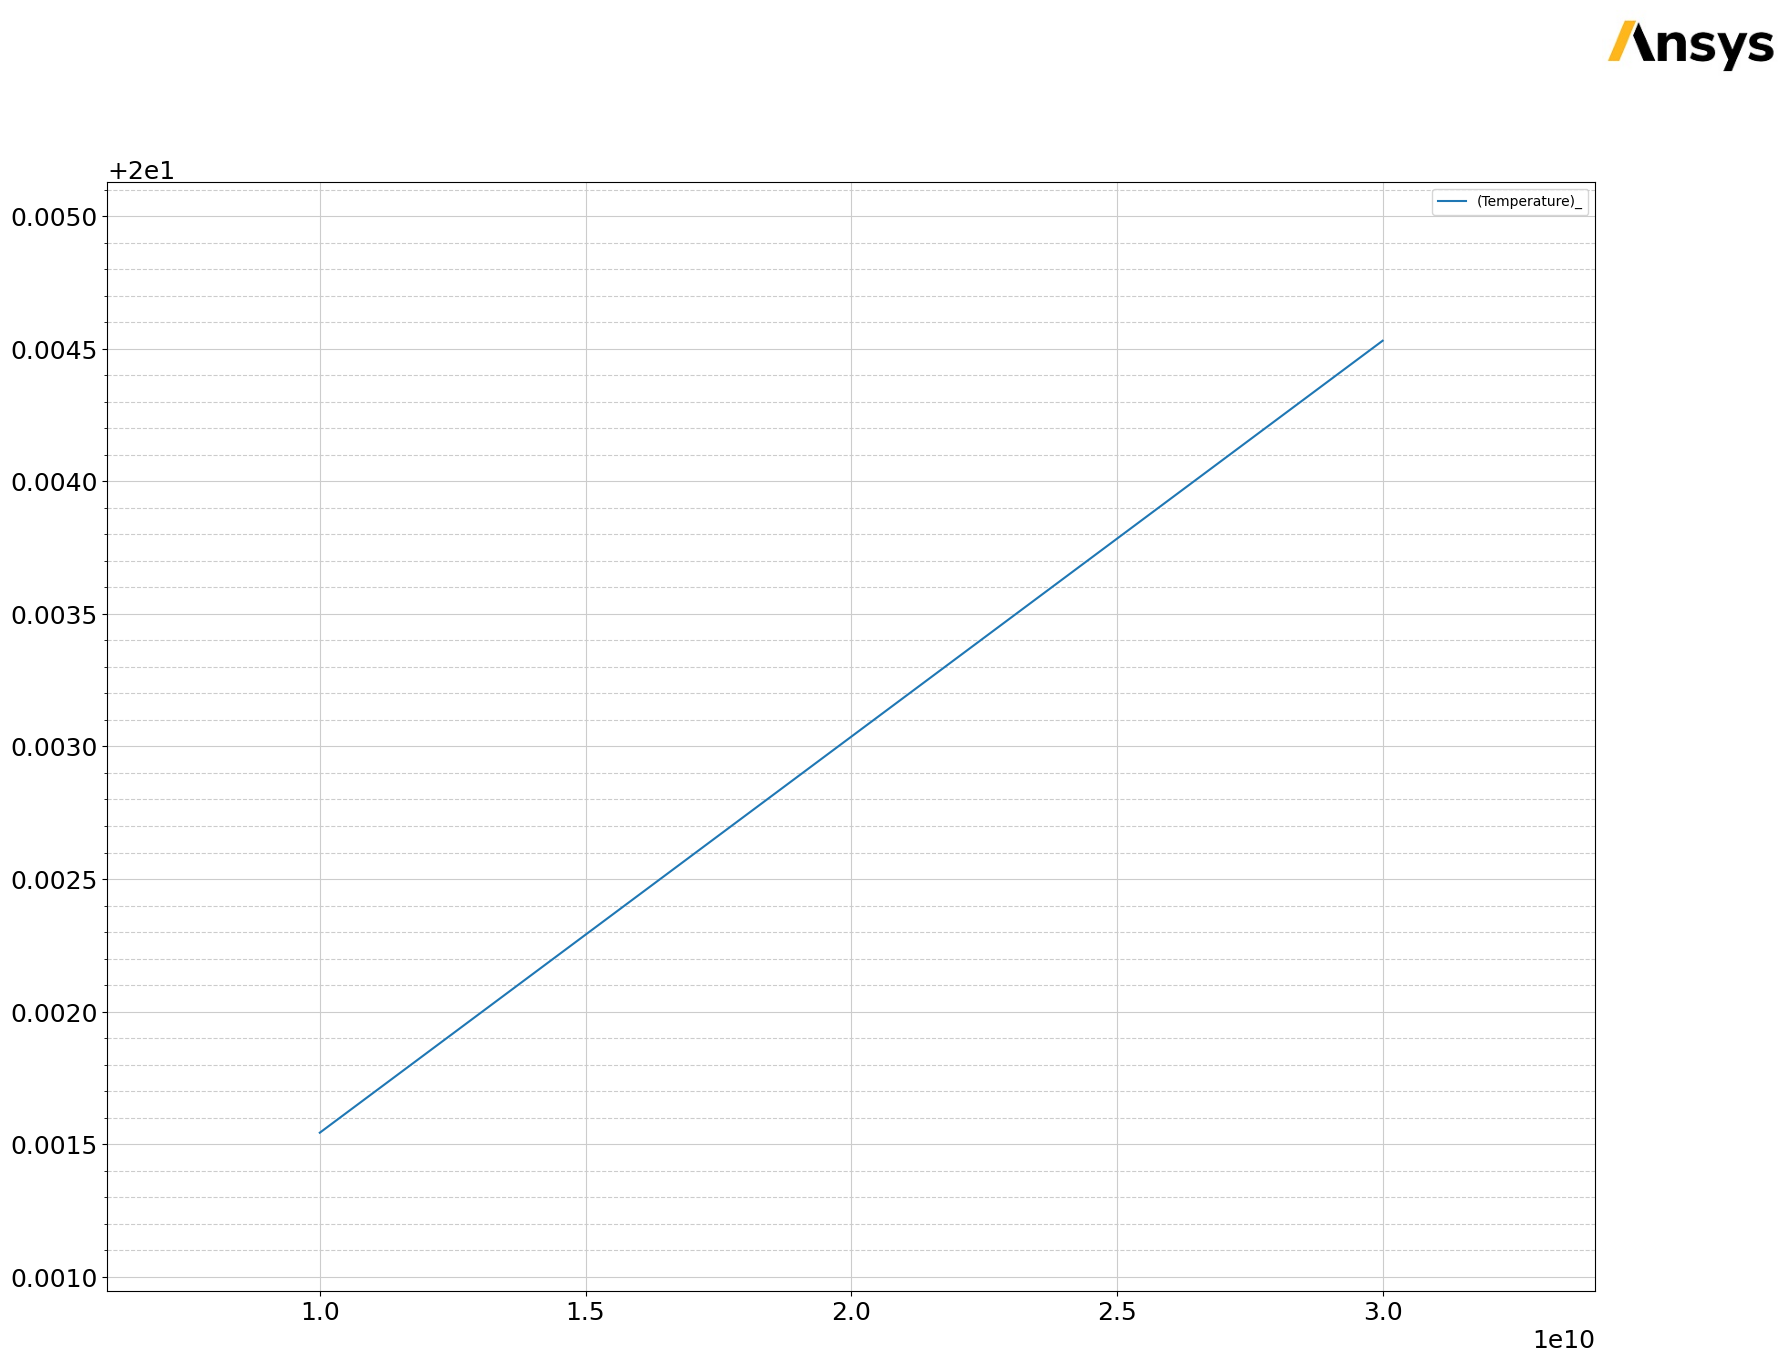

In [18]:
mech.post.create_fieldplot_cutplane(
    assignment=["implant:YZ"],
    quantity="Temperature",
    filter_objects=["implant_box"],
    intrinsics={"Time": "10s"},
)
mech.save_project()

data = mech.post.get_solution_data(
    expressions="Temperature",
    primary_sweep_variable="Time",
    context="Point1",
    report_category="Fields",
)
data.plot()

mech.post.plot_animated_field(
    quantity="Temperature",
    assignment="implant:YZ",
    plot_type="CutPlane",
    intrinsics={"Time": "10s"},
    variation_variable="Time",
    variations=["10s", "30s"],
    filter_objects=["implant_box"],
    show=False,
)

## Run a new thermal simulation

Initialize a new Icepak transient thermal analysis.

In [19]:
ipk = Icepak(solution_type="Transient", version=AEDT_VERSION)
ipk.design_solutions.problem_type = "TemperatureOnly"

PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)].


PyAEDT INFO: PyAEDT version 0.25.dev0.


PyAEDT INFO: Returning found Desktop session with PID 4340!


PyAEDT INFO: No project is defined. Project solved exists and has been read.


PyAEDT INFO: No consistent unique design is present. Inserting a new design.


PyAEDT INFO: Added design 'Icepak_KLB' of type Icepak.


PyAEDT INFO: Aedt Objects correctly read


## Copy geometries

Copy bodies from the HFSS project. The 3D component is not copied.

In [20]:
ipk.modeler.delete("Region")
ipk.copy_solid_bodies_from(hfss)

PyAEDT INFO: Modeler class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Deleted 1 Objects: Region.


True

## Link sources to EM losses

Link sources to the EM losses.
Assign external convection.

In [21]:
ipk.assign_em_losses(
    design=hfss.design_name,
    setup=hfss.setups[0].name,
    sweep="LastAdaptive",
    map_frequency=hfss.setups[0].props["Frequency"],
    surface_objects=ipk.get_all_conductors_names(),
)

PyAEDT INFO: Materials class has been initialized! Elapsed time: 0m 0sec


False

## Create setup

Create a setup and edit properties.
Simulation takes 30 seconds.

In [22]:
setup = ipk.create_setup()

setup.props["Stop Time"] = 30
setup.props["N Steps"] = 2
setup.props["Time Step"] = 5
setup.props["Convergence Criteria - Energy"] = 1e-12

## Create mesh region

Create a mesh region and change the accuracy level to 4.

In [23]:
bound = ipk.modeler["implant_box"].bounding_box
mesh_box = ipk.modeler.create_box(
    origin=bound[:3],
    sizes=[bound[3] - bound[0], bound[4] - bound[1], bound[5] - bound[2]],
)
mesh_box.model = False
mesh_region = ipk.mesh.assign_mesh_region([mesh_box.name])
mesh_region.UserSpecifiedSettings = False
mesh_region.update()
mesh_region.properties["Mesh Resolution"] = 4

PyAEDT INFO: Parsing C:\Users\ansys\AppData\Local\Temp\tmpzp3ybtup.ansys\mri\solved.aedt.


PyAEDT INFO: File C:\Users\ansys\AppData\Local\Temp\tmpzp3ybtup.ansys\mri\solved.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: aedt file load time 0.19675707817077637


PyAEDT WARNING: No mesh operation found.


PyAEDT WARNING: No mesh region found.


PyAEDT WARNING: Property Command is read-only.


PyAEDT INFO: Mesh class has been initialized! Elapsed time: 0m 0sec


PyAEDT WARNING: Property Command is read-only.


PyAEDT WARNING: Property Command is read-only.


## Create point monitor

Create a point monitor.

In [24]:
ipk.modeler.set_working_coordinate_system("implant")
ipk.monitor.assign_point_monitor(point_position=[0, 0, 0], monitor_name="Point1")
ipk.assign_openings(ipk.modeler["Region"].top_face_z)
# -

PyAEDT INFO: Boundary Opening Opening_LPCX1Q has been created.


Opening_LPCX1Q

## Release AEDT

Release AEDT and close the example.

In [25]:
hfss.save_project()
hfss.release_desktop()
# Wait 3 seconds to allow AEDT to shut down before cleaning the temporary directory.
time.sleep(3)

PyAEDT INFO: Project solved Saved correctly


PyAEDT INFO: Desktop has been released and closed.


## Clean up

All project files are saved in the folder ``temp_folder.name``. If you've run this example as a Jupyter notebook, you
can retrieve those project files. The following cell removes all temporary files, including the project folder.

In [26]:
temp_folder.cleanup()